Installing Unidecode library on current Jupyter Kernel, this library is used for decoding the non-ascii characters

In [1]:
import sys
!{sys.executable} -m pip install Unidecode

In [1]:
#please install Unidecode library if not present
#pip install Unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
from matplotlib.ticker import FuncFormatter
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
pd.options.display.float_format = '{:.2f}'.format

Reading all the input files and creating dataframes

In [3]:
#read files
c_df = pd.read_csv('data/companies.txt', sep='\t', encoding='latin-1',skip_blank_lines=True)
r2_df = pd.read_csv('data/rounds2.csv', sep=',' ,encoding='latin-1',skip_blank_lines=True)
map_df=pd.read_csv('data/mapping.csv', sep=',',skip_blank_lines=True)

#conver everything to lower case
c_df = c_df.applymap(lambda s:s.lower() if type(s) == str else s)
r2_df = r2_df.applymap(lambda s:s.lower() if type(s) == str else s)
map_df = map_df.applymap(lambda s:s.lower() if type(s) == str else s)
#convert country code to Upper case
c_df['country_code'] = c_df['country_code'].apply(lambda s:s.upper() if type(s) == str else s)

#decoding the permalink from c_df and r_df
c_df['permalink']=c_df['permalink'].apply( lambda x:  unidecode(x) if type(x)==str else x)
r2_df['company_permalink']=r2_df['company_permalink'].apply( lambda x:  unidecode(x) if type(x)==str else x)


#melt mapping file
mapping =pd.melt(map_df,id_vars='category_list', var_name='main_sector')
mapping=mapping[mapping.value!=0]
mapping['category']=mapping['category_list'].apply(lambda s: s.replace('0','na') if type(s)==str else s)
mapping.drop('category_list', axis=1,inplace =True)
mapping=mapping.set_index('category').reset_index()
mapping=mapping.dropna(axis=0) 




## Checkpoint 1: Data Cleaning 1

Assumptions:
<li>I have not done the data cleaning on Null or NaN, as we are filtering the data based on country and raised amount, there is no need to remove or impute any data.</li>
<li>NaN on raised amount are taken care as the aggregate functions will ignore NaN/null for any calculations.</li>
<li>Removing the data before will change the unique number of companies</li>

Cleaning the data by fixing the data encoding issue

In [5]:
r2_df.at[31863, 'company_permalink'] = c_df.at[18197, 'permalink']
r2_df.at[45176, 'company_permalink'] =c_df.at[26139, 'permalink']
r2_df.at[101036, 'company_permalink'] =c_df.at[58344, 'permalink']


 Q1. Number of unique companies in companies.txt?

qQ2. Number of Unique Companies in round2?

In [6]:
companies_unique_count = c_df['permalink'].nunique()
round2_unique_count = r2_df['company_permalink'].nunique()
print('companies_unique_count : ' + str(companies_unique_count) )
print('round2_unique_count : ' + str(round2_unique_count))

companies_unique_count : 66368
round2_unique_count : 66369


Q3. If both files have same companies?

In [7]:
df1=c_df['permalink']
df2=r2_df['company_permalink']
diff2 =df2[~df2.isin(df1)].dropna()
print(diff2)
print('No')




58473    /organization/magnet-tech-cPSc3cSSae
Name: company_permalink, dtype: object
No


Q4. Shape of master data?

In [8]:
#merging companies and round2 dataset

master_frame=pd.merge(c_df,r2_df,how='inner', left_on='permalink', right_on='company_permalink' )
master_frame.drop('company_permalink', axis=1, inplace=True)

master_frame.shape

(114948, 15)

## Checkpoint 2: Funding Type Analysis

Q1. Calculate the most representative value (median) of the investment amount for each of the four funding types (venture, angel, seed, and private equity) a

In [9]:
#null in raised_amount_usd
master_frame['raised_amount_usd'].isnull().sum()

19990

There are 19987 null rows in raised_amount_usd column, the aggregate functions will take care of these missing values, we will be ignoring these values in further calculations

In [10]:
#Creating grouped df 
funding_analysis_df_mean=master_frame.groupby('funding_round_type').mean()
funding_analysis_df_mean=funding_analysis_df_mean.sort_values('raised_amount_usd')
funding_analysis_df_mean=funding_analysis_df_mean.reset_index()


Q. Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them?


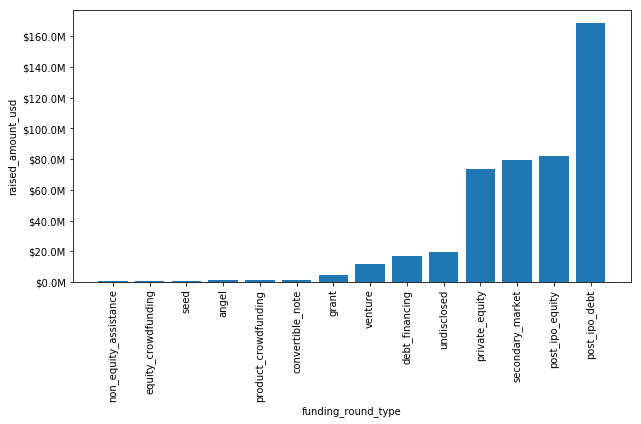

,funding_round_type,raised_amount_usd
7,venture,11748949.13


In [11]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)

plt.rcParams['figure.figsize'] = [10, 5]
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)

#df.sort_values('raised_amount_usd')
plt.xlabel('funding_round_type')
plt.ylabel('raised_amount_usd')
#plt.yscale('log')
plt.bar(funding_analysis_df_mean['funding_round_type'],funding_analysis_df_mean['raised_amount_usd'])
plt.xticks(rotation=90)
plt.show()

funding_analysis_df_mean.loc[(funding_analysis_df_mean.raised_amount_usd>=5000000) & (funding_analysis_df_mean.raised_amount_usd<=15000000)]

In [12]:
funding_analysis_df_mean

,funding_round_type,raised_amount_usd
0,non_equity_assistance,411203.05
1,equity_crowdfunding,538368.21
2,seed,719779.62
3,angel,958694.47
4,product_crowdfunding,1363131.07
5,convertible_note,1453438.54
6,grant,4300576.34
7,venture,11748949.13
8,debt_financing,17043526.02
9,undisclosed,19242370.23


We can clearly see that the average amount of funding for venture only lies between 5 to 15 Million$, we can also confirm this with the number of funding in venture within this range

Checking the number of investments in different funding types for investment amount between 5-15Million$

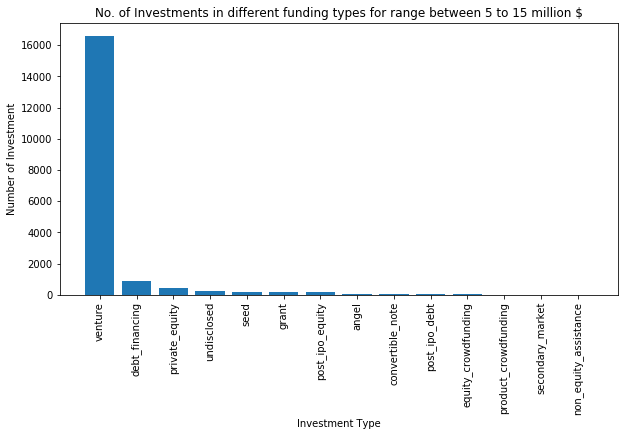

Investment type do you think is the most suitable for Spark Funds : venture


In [13]:
filter_df= master_frame.loc[(master_frame.raised_amount_usd>=5000000) & (master_frame.raised_amount_usd<=15000000)]
s_funding_type=filter_df.funding_round_type.value_counts()
plt.title('No. of Investments in different funding types for range between 5 to 15 million $')
plt.xlabel('Investment Type')
plt.ylabel('Number of Investment')
plt.bar(s_funding_type.index,s_funding_type)
plt.xticks(rotation=90)
plt.show()

investment_type =s_funding_type.idxmax()
print ('Investment type do you think is the most suitable for Spark Funds : ' + investment_type)

We can see a clear spike for venture, which means most of the investments are done in venture for amount between 5-15M$


## Checkpoint 3: Country Analysis

I have manually created all the country where English is official language

In [14]:
list_en=['ATG','AUS','BHS','BHR','BGD','BRB','BLZ','BWA','BDI','CMR','CAN','COK','CYP','DMA','ERI','ETH','FJI','GMB','GHA','GRD','GUY','IND','IRL','ISR','JAM','JOR','KEN','KIR','KWT','LSO','LBR','MWI','MYS','MDV','MLT','MHL','MUS','FSM','MMR','NAM','NRU','NZL','NGA','NIU','PAK','PLW','PNG','PHL','QAT','RWA','KNA','LCA','VCT','WSM','SYC','SLE','SGP','SLB','ZAF','LKA','SDN','SWZ','TZA','TON','TTO','TUV','UGA','ARE','GBR','USA','VUT','ZMB','ZWE']
series_en=pd.Series(list_en)
#series_en.head()
                

For the chosen investment type, make a data frame named top9 with the top nine countries (based on the total investment amount each country has received)

In [15]:
venture_df=master_frame[master_frame['funding_round_type']==investment_type]

top_countries_df=venture_df.groupby('country_code').sum()
top_countries_df=top_countries_df.sort_values(by=['raised_amount_usd'], ascending=False)
top_countries_df=top_countries_df.reset_index()
top_countries_df.head(10)


,country_code,raised_amount_usd
0,USA,422510842796.00
1,CHN,39835418773.00
2,GBR,20245627416.00
3,IND,14391858718.00
4,CAN,9583332317.00
5,FRA,7259536732.00
6,ISR,6907514579.00
7,DEU,6346959822.00
8,JPN,3363676611.00
9,SWE,3254952563.00


Analysing the Top 3 English-Speaking Countries


In [16]:
top9=top_countries_df.head(9)
print('Top nine countries (based on the total investment amount each country has received)')
top9['country_code']

Top nine countries (based on the total investment amount each country has received)


0    USA
1    CHN
2    GBR
3    IND
4    CAN
5    FRA
6    ISR
7    DEU
8    JPN
Name: country_code, dtype: object

Analysing the Top 3 English-Speaking Countries		


In [17]:
top_3_countrycode = top9['country_code'][top9['country_code'].isin(list_en)].head(3).tolist()
(top_3_countrycode)

['USA', 'GBR', 'IND']

## Checkpoint 4: Sector Analysis 1

the first string before the vertical bar will be considered the primary sector.  
Code for a merged data frame with each primary sector mapped to its main sector (the primary sector should be present in a separate column).

In [18]:
#splitting the column value by | and accepting the first field as primary sector
master_frame['primary_sector'] = master_frame['category_list'].apply(lambda s: s.split('|')[0] if type(s)==str else s)
merged_df= pd.merge(master_frame, mapping[['category','main_sector']], how='left', left_on='primary_sector', right_on='category')
merged_df.drop('category', axis=1, inplace=True)
merged_df.head(2)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,media,operating,IND,16,mumbai,mumbai,NaN,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,b,5/1/2015,10000000.00,media,Entertainment
1,/organization/-qounter,:qounter,http://www.qounter.com,application platforms|real time|social network...,operating,USA,de,de - other,delaware city,04-09-2014,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,a,14-10-2014,nan,application platforms,"News, Search and Messaging"


## Checkpoint 5: Sector Analysis 2

In [19]:
sector_analysis = merged_df[(merged_df['country_code'].isin(top_3_countrycode)) & (merged_df['funding_round_type']==investment_type) & (merged_df.raised_amount_usd.between(left=5000000, right=15000000))]

Creating Dataframe for top 3 country

In [20]:
d1 = sector_analysis[sector_analysis['country_code']==top_3_countrycode[0]]
d2 = sector_analysis[sector_analysis['country_code']==top_3_countrycode[1]]
d3 = sector_analysis[sector_analysis['country_code']==top_3_countrycode[2]]

Create Data frame for:
    <li>The total number (or count) of investments for each main sector in a separate column</li>
    <li>The total amount invested in each main sector in a separate column</li>

In [21]:
d1_df=pd.DataFrame()
d2_df=pd.DataFrame()
d3_df=pd.DataFrame()

d1_df['sector_cnt'] = d1.groupby(by=['main_sector','country_code']).count()['raised_amount_usd']
d2_df['sector_cnt'] = d2.groupby(by=['main_sector','country_code']).count()['raised_amount_usd']
d3_df['sector_cnt'] = d3.groupby(by=['main_sector','country_code']).count()['raised_amount_usd']

d1_df['sector_sum'] = d1.groupby(by=['main_sector','country_code']).sum()
d2_df['sector_sum'] = d2.groupby(by=['main_sector','country_code']).sum()
d3_df['sector_sum'] = d3.groupby(by=['main_sector','country_code']).sum()



Merge Above 2 dataframes on main_sector

In [22]:
test=pd.DataFrame()
test['count'] = sector_analysis.groupby(by=['main_sector','country_code']).count()['raised_amount_usd']
test['sum']=sector_analysis.groupby(by=['main_sector','country_code']).sum()

test.reset_index()
#total number of investment
test.groupby(by=['country_code']).sum()


,count,sum
country_code,,
GBR,621,5379078691.00
IND,328,2949543602.00
USA,12063,107757097294.00


In [23]:
D1=pd.merge(d1,d1_df, on='main_sector')
D2=pd.merge(d2,d2_df, on='main_sector')
D3=pd.merge(d3,d3_df, on='main_sector')

Total Number of Investment and Amount of Investment

In [24]:
s1=d1_df.sum()
s2=d2_df.sum()
s3=d3_df.sum()
print('Total number of Investments (count)')
print(top_3_countrycode[0] +' : ' +str(s1[0]))
print(top_3_countrycode[1] +' : ' +str(s2[0]))
print(top_3_countrycode[2] +' : ' +str(s3[0]))
print('-------------------------------------')
print('Total amount of investment (USD)')
print(top_3_countrycode[0] +' : ' +str(s1[1]))
print(top_3_countrycode[1] +' : ' +str(s2[1]))
print(top_3_countrycode[2] +' : ' +str(s3[1]))


Total number of Investments (count)
USA : 12063.0
GBR : 621.0
IND : 328.0
-------------------------------------
Total amount of investment (USD)
USA : 107757097294.0
GBR : 5379078691.0
IND : 2949543602.0


Sectorwise Report

In [25]:
print('COUNTRY : ' + top_3_countrycode[0] + '\nSector wise count')
d1_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt']

COUNTRY : USA
Sector wise count


main_sector                              country_code
Others                                   USA             2950
Social, Finance, Analytics, Advertising  USA             2714
Cleantech / Semiconductors               USA             2350
News, Search and Messaging               USA             1583
Health                                   USA              909
Manufacturing                            USA              799
Entertainment                            USA              591
Automotive & Sports                      USA              167
Name: sector_cnt, dtype: int64

In [26]:
print('COUNTRY : ' + top_3_countrycode[1] + '\nSector wise count')
d2_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt']

COUNTRY : GBR
Sector wise count


main_sector                              country_code
Others                                   GBR             147
Social, Finance, Analytics, Advertising  GBR             133
Cleantech / Semiconductors               GBR             130
News, Search and Messaging               GBR              73
Entertainment                            GBR              56
Manufacturing                            GBR              42
Health                                   GBR              24
Automotive & Sports                      GBR              16
Name: sector_cnt, dtype: int64

In [27]:
print('COUNTRY : ' + top_3_countrycode[2] + '\nSector wise count')
d3_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt']

COUNTRY : IND
Sector wise count


main_sector                              country_code
Others                                   IND             110
Social, Finance, Analytics, Advertising  IND              60
News, Search and Messaging               IND              52
Entertainment                            IND              33
Manufacturing                            IND              21
Cleantech / Semiconductors               IND              20
Health                                   IND              19
Automotive & Sports                      IND              13
Name: sector_cnt, dtype: int64

In [28]:
top_sector_count_wise=[]
top_sector_count_wise.append(d1_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt'].index[0])
top_sector_count_wise.append(d2_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt'].index[0])
top_sector_count_wise.append(d3_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt'].index[0])
# print('top sector for c1,c2,c3: ' + str(top_sector_count_wise))
secondtop_sector_count_wise=[]
secondtop_sector_count_wise.append(d1_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt'].index[1])
secondtop_sector_count_wise.append(d2_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt'].index[1])
secondtop_sector_count_wise.append(d3_df.sort_values(by='sector_cnt', ascending=False)['sector_cnt'].index[1])
# print('second top sector for c1,c2,c3: ' + str(secondtop_sector_count_wise))

For point 3 (top sector count-wise), which company received the highest investment?

In [29]:
#print('For point 3 (top sector count-wise), which company received the highest investment?')
permalink_hi_inv_top_sctr=[]
permalink_hi_inv_top_sctr.append(D1[D1['main_sector']==top_sector_count_wise[0][0]].groupby(by=['permalink']).sum().sort_values(by='raised_amount_usd', ascending=False).index[0])
permalink_hi_inv_top_sctr.append(D2[D2['main_sector']==top_sector_count_wise[1][0]].groupby(by=['permalink']).sum().sort_values(by='raised_amount_usd', ascending=False).index[0])
permalink_hi_inv_top_sctr.append(D3[D3['main_sector']==top_sector_count_wise[2][0]].groupby(by=['permalink']).sum().sort_values(by='raised_amount_usd', ascending=False).index[0])
print(permalink_hi_inv_top_sctr)
i=0
for link in permalink_hi_inv_top_sctr:
    i=i+1
    print('C' + str(i) + '--> ' +str(master_frame['name'][master_frame['permalink']==link].unique()[0]))

['/organization/virtustream', '/organization/electric-cloud', '/organization/firstcry-com']
C1--> virtustream
C2--> electric cloud
C3--> firstcry.com


For point 4 (second best sector count-wise), which company received the highest investment?

In [30]:
print('For point 4 (second best sector count-wise), which company received the highest investment?')
permalink_hi_inv_sectop_sctr=[]
permalink_hi_inv_sectop_sctr.append(D1[D1['main_sector']==secondtop_sector_count_wise[0][0]].groupby(by=['permalink']).sum().sort_values(by='raised_amount_usd', ascending=False).index[0])
permalink_hi_inv_sectop_sctr.append(D2[D2['main_sector']==secondtop_sector_count_wise[1][0]].groupby(by=['permalink']).sum().sort_values(by='raised_amount_usd', ascending=False).index[0])
permalink_hi_inv_sectop_sctr.append(D3[D3['main_sector']==secondtop_sector_count_wise[2][0]].groupby(by=['permalink']).sum().sort_values(by='raised_amount_usd', ascending=False).index[0])

i=0
for link in permalink_hi_inv_sectop_sctr:
    i=i+1
    print('C' + str(i) + '--> ' +str(master_frame['name'][master_frame['permalink']==link].unique()[0]))

For point 4 (second best sector count-wise), which company received the highest investment?
C1--> sst inc. (formerly shotspotter)
C2--> celltick technologies
C3--> manthan systems


## Checkpoint 6: Plots

1. A plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

In [31]:
#average amount of investment
funding_analysis_df_mean=filter_df.groupby('funding_round_type').mean()
funding_analysis_df_mean=funding_analysis_df_mean.sort_values('raised_amount_usd')

funding_analysis_df_mean=funding_analysis_df_mean.reset_index()
avg_inv_df=funding_analysis_df_mean[funding_analysis_df_mean['funding_round_type'].isin(['venture','seed','private_equity'])]
avg_inv_df =avg_inv_df.sort_values('funding_round_type', ascending=False).reset_index().drop('index', axis=1)
avg_inv_df.head()

,funding_round_type,raised_amount_usd
0,venture,8888550.51
1,seed,6610420.41
2,private_equity,9283495.68


In [32]:
funding_analysis_fraction_df=filter_df.groupby('funding_round_type').sum()

total_funding = filter_df['raised_amount_usd'].sum()
# funding_analysis_fraction_df=funding_analysis_df_mean.sort_values('raised_amount_usd')
# funding_analysis_fraction_df=funding_analysis_df_mean.reset_index()
funding_analysis_fraction_df['fraction']=funding_analysis_fraction_df['raised_amount_usd'].apply(lambda x: x/total_funding * 100)
funding_analysis_fraction_df=funding_analysis_fraction_df.reset_index()
df_fraction = funding_analysis_fraction_df[funding_analysis_fraction_df['funding_round_type'].isin(['venture','seed','private_equity'])]
df_fraction.sort_values('funding_round_type')

,funding_round_type,raised_amount_usd,fraction
8,private_equity,3982619646.00,2.39
11,seed,1341915343.00,0.81
13,venture,147532161297.00,88.65


In [33]:
import seaborn as sns
sns.set(style="whitegrid")

In [34]:
avg_inv_df.index
df_fraction.index

Int64Index([8, 11, 13], dtype='int64')

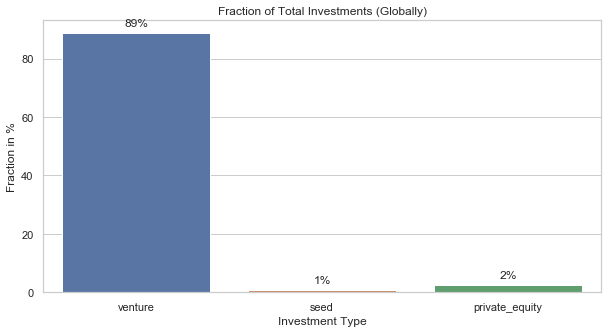

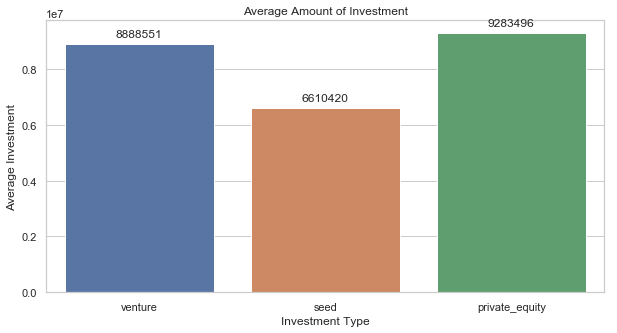

In [35]:


ay = sns.barplot(x="funding_round_type", y="fraction", data=df_fraction, order=avg_inv_df['funding_round_type'])
for p in ay.patches:
    ay.annotate(format(p.get_height(), '.0f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title("Fraction of Total Investments (Globally)")
plt.xlabel('Investment Type')
plt.ylabel('Fraction in %')
plt.show(ay)

#----------------------

ax = sns.barplot(x="funding_round_type", y="raised_amount_usd", data=avg_inv_df,order=avg_inv_df['funding_round_type'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title("Average Amount of Investment")
plt.xlabel('Investment Type')
plt.ylabel('Average Investment')
plt.show(ax)



2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

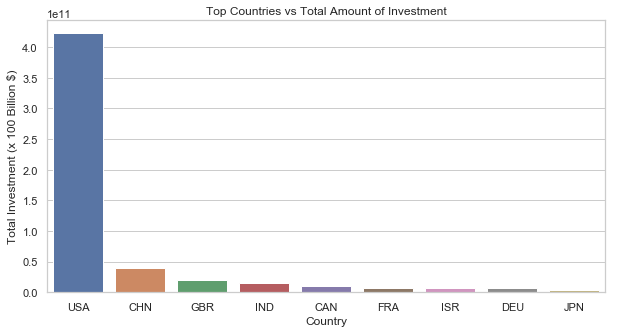

In [36]:


ax = plt.subplots()
ax = sns.barplot(x="country_code", y="raised_amount_usd", data=top9)
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
#ax=ax.set(yscale="log")
plt.title("Top Countries vs Total Amount of Investment")
plt.xlabel('Country')
plt.ylabel('Total Investment (x 100 Billion $)')
plt.show(ax)

3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

In [37]:
c1_plot3=D1[D1['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])][['country_code','main_sector','sector_cnt']].drop_duplicates()
c2_plot3=D2[D2['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])][['country_code','main_sector','sector_cnt']].drop_duplicates()
c3_plot3=D3[D3['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','News, Search and Messaging'])][['country_code','main_sector','sector_cnt']].drop_duplicates()



In [38]:
plot3=pd.concat([c1_plot3, c2_plot3,c3_plot3], axis=0, sort=True)
plot3.head(9)

,country_code,main_sector,sector_cnt
0,USA,"Social, Finance, Analytics, Advertising",2714
4297,USA,Others,2950
8046,USA,Cleantech / Semiconductors,2350
0,GBR,"Social, Finance, Analytics, Advertising",133
189,GBR,Cleantech / Semiconductors,130
416,GBR,Others,147
33,IND,Others,110
143,IND,"Social, Finance, Analytics, Advertising",60
236,IND,"News, Search and Messaging",52


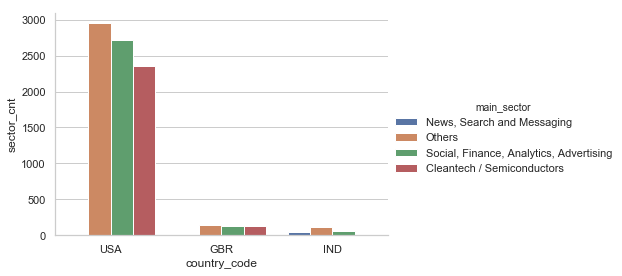

In [39]:
g = sns.catplot(x="country_code", y="sector_cnt",
                 hue="main_sector",
                 data=plot3, kind="bar", 
                 hue_order = ['News, Search and Messaging','Others', 'Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'],
                 height=4, aspect=1.5);
